# Paper Figures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import include.colors as colortools
from matplotlib.patches import Circle
import matplotlib as mpl
import matplotlib.colors as mplcolors
import include.helium as helium
import platform
from scipy.integrate import simps
import pickle

from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('retina')

plotDir = "./plots/"

In [2]:
runcell = False
if runcell:
    import os
    fm = mpl.font_manager.json_load(os.path.expanduser("~/.cache/matplotlib/fontlist-v310.json"))
    fm.findfont("serif", rebuild_if_missing=False)
    
if 'Darwin' in platform.system():
    %config InlineBackend.figure_format = 'svg'
    %matplotlib inline
    
try:
    %load_ext watermark
    %watermark -u -v -m -p numpy,scipy,matplotlib -g -n -t -z
except: pass

last updated: Fri May 29 2020 10:36:15 EDT 

CPython 3.7.7
IPython 7.13.0

numpy 1.18.1
scipy 1.4.1
matplotlib 3.1.3

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 2edda2ffcb8dad1f80d26f588cd9c680166135f6


## Load some QMC Data

Load the data after generation and analysis in [experimental_nanopore_structure.ipynb](./experimental_nanopore_structure.ipynb).

In [28]:
def Tkey(T):
    return f'T = {T:3.1f} K'

def μkey(μ):
    return f'u = {μ:.2f}'

with open('./data/radial_density.pickle', 'rb') as pfile:
    ρrad = pickle.load(pfile)
    
with open('./data/chemical_potential.pickle', 'rb') as pfile:
    μqmc = pickle.load(pfile)
    
with open('./data/coverage.pickle', 'rb') as pfile:
    ρcov = pickle.load(pfile)
    
with open('./data/density_estimators.pickle', 'rb') as pfile:
    ρqmc,Δρqmc = pickle.load(pfile)

### Load some Experimental Data

Load the data after generation and analysis in [He_Ar_MCM_scattering.ipynb](./He_Ar_MCM_scattering.ipynb).

In [4]:
with open('./data/sqw.pickle', 'rb') as pfile:
    n_fill,Emesh,Qmesh,Q,E_exp,I,ΔI = pickle.load(pfile)

## Setup colors for plots

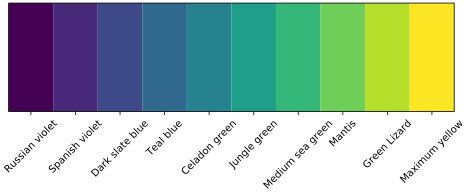

In [5]:
plot_colors = colortools.get_linear_colors('viridis',10)
cnames,color_names = colortools.view_colors(plot_colors)

In [8]:
color_names = {'Russian violet': '#440154','Spanish violet': '#482878','Dark slate blue': '#3e4989',
 'Teal blue': '#31688e', 'Celadon green': '#26828e', 'Jungle green': '#1f9e89', 'Medium sea green': '#35b779',
 'Mantis': '#6ece58','Green Lizard': '#b5de2b','Maximum yellow': '#fde725'}

<div style="background:#3aba76; padding:10px; border-radius:5px"> 
    <h2>Experimental Scattering Data</h2>
</div>

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


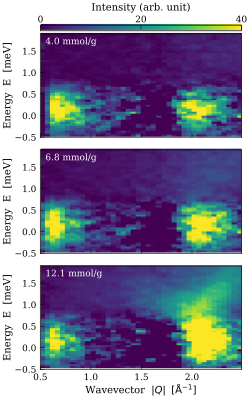

In [9]:
plt.style.reload_library()
with plt.style.context('./include/aps.mplstyle'):
    figsize= plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(3,1,figsize=(figsize[0],1.5*figsize[0]),sharex=True, sharey=True, constrained_layout=True)
    
    pcm = []
    for i,cn in enumerate(n_fill):
        pcm.append(ax[i].pcolormesh(Qmesh,Emesh,I[cn], edgecolor='None', rasterized=True, vmin=0,vmax=40))
        ax[i].annotate(f'{cn:.1f} mmol/g', xy=(0.025,0.9), xytext=(0.025,0.9),
                         xycoords=ax[i].transAxes, fontsize=9, color='w')
    
    ax[2].set_xlim([0.5,2.49])
    ax[2].set_ylim(-0.5,1.9)
    
    for cax in ax:
        cax.set_ylabel('Energy  E  [meV]')
    ax[2].set_xlabel(r'Wavevector  $\vert Q \vert \;\; [\mathrm{\AA}^{-1}]$')
    

    # Horizontal colorbar to ensure square figures are the same size 
    ticks=[0,20,40]
    loc = 'upper center'
    vshift = 0.09

    axins1 = inset_axes(ax[0],
                    width="100%",  # width = 50% of parent_bbox width
                    height="5.5%",  # height : 5%
                    loc=loc,
                    bbox_to_anchor=(0.0, vshift, 1, 1),
                   bbox_transform=ax[0].transAxes,
                   borderpad=0)
  
    cb = fig.colorbar(pcm[0], cax=axins1, ticks=ticks, orientation='horizontal')
    cb.set_label('Intensity (arb. unit)',labelpad=5)
    
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')
    cb.ax.xaxis.set_tick_params(pad=1)

    plt.savefig('./plots/scattering.pdf',dpi=300) 

In [ ]:
def cart2pol(x, y):
    """convert from cartesian to polar coordinates"""
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    """convert from polar to cartesian coordinates"""
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [10]:
from scipy.interpolate import griddata
runcell = False
if runcell:
    V_data = np.load("data/V_3D_-20.0_20.0_-20.0_20.0_-6.10_6.10_101_CVFF.npz")
    Vmesh = V_data["V"][:,:,50].flatten()
    x = V_data["x_grid"].flatten()
    y = V_data["y_grid"].flatten()
    z = Vmesh
    extent = V_data["extent"]
    
    grid_x, grid_y = np.mgrid[extent[0]:extent[1]:1001j, extent[2]:extent[3]:1001j]
    single_grid_z_nearest = griddata((x,y), Vmesh, (grid_x, grid_y), method='nearest')
    single_grid_z_linear = griddata((x,y), Vmesh, (grid_x, grid_y), method='linear')
    single_grid_z_cubic = griddata((x,y), Vmesh, (grid_x, grid_y), method='cubic')
    extent_single = (np.min(x),np.max(x),np.min(y),np.max(y))
    np.savez("data/manybody_potential_single",
             single_grid_z_nearest=single_grid_z_nearest,
             single_grid_z_linear=single_grid_z_linear,
             single_grid_z_cubic=single_grid_z_cubic,
             extent_single=extent_single)
else:
    manybody_potential_data = np.load("data/manybody_potential_single.npz")
    single_grid_z_nearest = manybody_potential_data["single_grid_z_nearest"]
    single_grid_z_linear = manybody_potential_data["single_grid_z_linear"]
    single_grid_z_cubic = manybody_potential_data["single_grid_z_cubic"]
    extent_single = manybody_potential_data["extent_single"]

In [11]:
runcell = False
if runcell:
    from scipy.interpolate import griddata
    xmin = -60
    xmax = 60
    ymin = -60
    ymax = 60
    extent_many = (xmin,xmax,ymin,ymax)
    grid_x, grid_y = np.mgrid[xmin:xmax:10001j, ymin:ymax:10001j]
    many_grid_z_nearest = griddata((xx,yy), zz, (grid_x, grid_y), method='nearest')
    many_grid_z_linear = griddata((xx,yy), zz, (grid_x, grid_y), method='linear')
    many_grid_z_cubic = griddata((xx,yy), zz, (grid_x, grid_y), method='cubic')
    np.savez("data/manybody_potential_many",
             many_grid_z_nearest=many_grid_z_nearest,
             many_grid_z_linear=many_grid_z_linear,
             many_grid_z_cubic=many_grid_z_cubic,
             extent_many=extent_many)
else:
    manybody_potential_data = np.load("data/manybody_potential_many.npz")
    extent_many = manybody_potential_data["extent_many"]
    many_grid_z_nearest = manybody_potential_data["many_grid_z_nearest"]
    many_grid_z_linear = manybody_potential_data["many_grid_z_linear"]    
    many_grid_z_cubic = manybody_potential_data["many_grid_z_cubic"]    

<div style="background:#3aba76; padding:10px; border-radius:5px"> 
    <h2>Many-Body Potential Colormap</h2>
    </div>

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


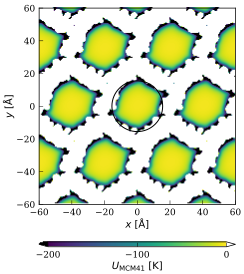

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mpl_colors
from copy import copy

plt.style.reload_library()
with plt.style.context('./include/aps.mplstyle'):
    figsize=plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(figsize=(figsize[0],1*figsize[0]),constrained_layout=True)
    ax.set_aspect('equal')
    
    # setup a masked color pallette
    palette = copy(plt.cm.viridis)
    palette.set_over('w', 1.0)
    palette.set_under('k', 1.0)
    
    #im = ax.imshow(many_grid_z_nearest.T,origin='lower',extent=extent_many,vmax=200,vmin=-200,cmap="viridis")
    #im = ax.imshow(many_grid_z_linear.T,origin='lower',extent=extent_many,vmax=100,vmin=-200,cmap="viridis",interpolation="none", rasterized=True)
    
    im = ax.imshow(many_grid_z_linear.T,origin='lower',extent=extent_many,norm=mpl_colors.Normalize(vmin=-200, vmax=0),cmap=palette,interpolation="none", rasterized=True)

    #im = ax.imshow(many_grid_z_cubic.T,origin='lower',extent=extent_many,vmax=200,vmin=-200,cmap="viridis")
    circ = Circle((0,0),15.51,facecolor='None',edgecolor='k')
    ax.add_patch(circ)
    
    # Vertical Colorbar
#     aspect = 20
#     divider = make_axes_locatable(ax)
#     width = axes_size.AxesY(ax, aspect=1.0/aspect)
#     pad = axes_size.Fraction(0.5, width)
#     cax = divider.append_axes("right", size=width, pad=pad)
#     cbar = plt.colorbar(im, cax=cax)
    
    top = False
    loc = 'lower center'
    vshift = -0.225
    ticks=[-200,-100,0]
    if top:
        loc = 'upper center'
        vshift = 0.075

    # Horizontal colorbar to ensure square figures are the same size
    axins1 = inset_axes(ax,
                    width="100%",  # width = 50% of parent_bbox width
                    height="2.5%",  # height : 5%
                    loc=loc,
                    bbox_to_anchor=(0.0, vshift, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
  
    cb = fig.colorbar(im, cax=axins1, ticks=ticks, orientation='horizontal', extend='both')
    cb.set_label(r'$U_\mathrm{MCM41}$ $\mathrm{[K]}$')
    
    if top:
        cb.ax.xaxis.set_ticks_position('top')
        cb.ax.xaxis.set_label_position('top')

    
    ax.set_xlabel(r'$x$ $\mathrm{[\AA]}$')
    ax.set_ylabel(r'$y$ $\mathrm{[\AA]}$')
    
    fig.savefig('./plots/manybodyPotential.pdf',dpi=300)
 

In [ ]:
mcm41_crystal_image = plt.imread("data/mcm41_cut_120x120.png")
ax1,ax2,ay1,ay2 = np.load('data/mcm41UCdata.npy')
pore_radius = 15.51
from matplotlib.patches import Circle
plt.style.reload_library()
with plt.style.context('./include/aps.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(figsize=(figsize[0],figsize[0]),constrained_layout=True, dpi=600)
    ax.imshow(mcm41_crystal_image,extent=extent_many,interpolation="none", rasterized=True)
    ax.plot([0],[0],marker="x",color="k", ms=4, mew=1)
    ax.plot([],[],marker="o",color=color_names['Russian violet'],label=r"$\mathrm{Si}$",ms=4,linestyle="None")
    ax.plot([],[],marker="o",color=color_names['Dark slate blue'],label=r"$\mathrm{O}$",ms=3,linestyle="None")
    ax.plot([],[],marker="o",color=color_names['Maximum yellow'],label=r"$\mathrm{H}$",ms=2,linestyle="None")
    l = ax.legend(loc="center",bbox_to_anchor=(.5 - (ax1/120),.5),handlelength=1)
    circ = Circle((0,0),pore_radius,facecolor='None',edgecolor="k",linestyle="-")
    ax.add_patch(circ)
    xl= ax.set_xlabel(r'$x$ $\mathrm{[\AA]}$')
    ax.set_ylabel(r'$y$ $\mathrm{[\AA]}$')
    #fig.tight_layout(pad=0.4, w_pad=0.0, h_pad=0.0)
    #l = ax.legend(loc="center",bbox_to_anchor=(0.0,23.0),bbox_transform=xl.get_transform(),columnspacing=0,handlelength=1,ncol=3)
    
    fig.savefig('plots/mcm41_crystal_structure.png',bbox_inches=None,pad_inches=0,dpi=300,constrained_layout=True)
    fig.savefig('plots/mcm41_crystal_structure.pdf',bbox_inches=None,pad_inches=0,dpi=600,constrained_layout=True)
    fig.savefig('plots/mcm41_crystal_structure.svg',bbox_inches=None,pad_inches=0,dpi=300,constrained_layout=True)    

<div style="background:#3aba76; padding:10px; border-radius:5px"> 
<h2>Effective Potential Inside the Pore </h2>
</div>

In [ ]:
from scipy.special import ellipk, ellipe

def V(rho,sigma,n,R):
    pf = np.pi*n*(sigma**3)/3.0
    t9 = v9(rho/R)*((sigma/R)**9)
    t3 = v3(rho/R)*((sigma/R)**3)
    return pf*(t9-t3)

def Vshell(rho,sigma,n,R1,R2):
    pf = np.pi*n*(sigma**3)/3.0
    t9 = v9(rho/R1)*((sigma/R1)**9)
    t3 = v3(rho/R1)*((sigma/R1)**3)
    y9 = v9(rho/R2)*((sigma/R2)**9)
    y3 = v3(rho/R2)*((sigma/R2)**3)
    return pf*(y3-y9+t9-t3)

def v9(x):
    pf = 1.0/(240.0*((1.0-(x**2))**9))
    t1 = (1091.0 + (11156.0*(x**2)) + (16434.0*(x**4)) + (4052.0*(x**6)) + (35*(x**8)))*ellipe(x**2)
    t2 = 8.0 * (1.0-(x**2)) * (1.0 + (7.0*(x**2))) * (97.0 + (134.0*(x**2)) + (25.0*(x**4))) * ellipk(x**2)
    return pf*(t1-t2)

def v3(x):
    pf = 2.0/((1.0-(x**2))**3)
    t1 = (7.0 + (x**2)) * ellipe(x**2)
    t2 = 4.0 * (1.0-(x**2)) * ellipk(x**2)
    return pf*(t1-t2)

def U_LJ(r,sigma,epsilon):
    pf = 4.0 * epsilon
    t12 = (sigma/r)**12
    t6 = (sigma/r)**6
    return pf * (t12 - t6)

In [ ]:
run_cell = False

if run_cell:
    R = 15.51
    R2 = R + 3.76
    ss = 3.02250
    es = 3.61361
    
    # sigma and epsilon parameters for atoms in silica and helium
    # See https://doi.org/10.1016/j.apsusc.2015.01.084 and https://doi.org/10.1016/S0927-7757(01)00628-8
    sigmaarr = np.array([(3.804,3.033,2.846,2.640,3.405,2.782)],dtype=[('Si','f'),('O','f'),('H','f'),('He','f'),('Ar','f'),('Ne','f')])
    epsilonarr = np.array([(155.858,48.115,0.0503,10.9,119.8,37.29134539)],dtype=[('Si','f'),('O','f'),('H','f'),('He','f'),('Ar','f'),('Ne','f')])

    # functions to mix the LJ parameters
    # See https://doi.org/10.1016/S0927-7757(01)00628-8
    def mixsigma(s1,s2):
        return (s1+s2)/2.0

    def mixepsilon(e1,e2):
        return (e1*e2)**0.5
    
    r = np.linspace(0,17,10000)
    V_MCM41 = V(r,3.44,1.59,R)
    
    # Argon density
    SA = 915.0*1e20 #surface area \AA^2/g
    MLC = 8.994e-3 #monolayer argon coverage mol/g
    n_2d = 6.022140857e23*MLC/SA #argon atoms per \AA^2
    n_3d = n_2d/3.5
    n_3dArPaulWiki = n_3d

    # Neon Density
    argonMass = 39.948 #g/mole
    argonRadius = 188e-12 #m
    NA = 6.022140758e23 #atoms/mole
    L_to_m3 = 0.001 #m^3/L

    argonDensitySolid = 1616 #g/L
    n_3dArFromSolidDensity = (((argonDensitySolid/L_to_m3)/argonMass)*NA*((1e-10)**3)) #atoms/m^3

    argonDensityLiquid = 1395.4 #g/L
    n_3dArFromLiquidDensity = (((argonDensityLiquid/L_to_m3)/argonMass)*NA*((1e-10)**3)) #atoms/m^3

    argonDensityArr = [n_3dArFromSolidDensity,n_3dArFromLiquidDensity,n_3dArPaulWiki]

    print(r'{:.3f}$\mathrm{{Å}}^{{-3}}$'.format(n_3d))
    
    sArHe = mixsigma(sigmaarr['He'],sigmaarr['Ar'])
    eArHe = mixepsilon(epsilonarr['He'],epsilonarr['Ar'])
    print(sArHe)
    print(eArHe)
    
    vdwrAr = 1.88
    
    V_ArArr = []
    for n_3dAr in argonDensityArr:
        V_Ar = Vshell(r,sArHe,eArHe*n_3dAr,R-(vdwrAr*2),R)
        V_ArArr.append(V_Ar)
        
    effective_potential_Ar = (np.array(V_ArArr) + V_MCM41)
    effective_potential_Ar2 = np.zeros((effective_potential_Ar.shape[1],4))
    effective_potential_Ar2[:,0] = r
    effective_potential_Ar2[:,1:] = effective_potential_Ar.T
    
    np.save("data/effective_potential_Ar",effective_potential_Ar2)
    np.save("data/argon_density",np.array(argonDensityArr))
    np.savez("data/effective_potential_MCM41",effective_potential=V_MCM41,distance_from_center=r)
    
    # find Minimum of potentials
    def minimize_me_V(r,shell_density,R=15.51,shell_thickness=3.76,shell_sigma=3.0225,shell_epsilon=36.13613,medium_sigma=3.44,medium_n=1.59):
        V_medium = V(r,medium_sigma,medium_n,R)
        V_shell = Vshell(r,shell_sigma,shell_epsilon*shell_density,R-shell_thickness,R)
        return V_medium + V_shell
    
    from scipy.optimize import minimize
    shell_density = n_3dArFromLiquidDensity
    R=15.51
    shell_thickness=3.76
    shell_sigma=3.0225
    shell_epsilon=36.13613
    sigma_medium=3.44
    n_medium=1.59
    
    result = minimize(minimize_me_V,9.195,args=(shell_density,R,shell_thickness,shell_sigma,shell_epsilon,sigma_medium,n_medium))

    def find_minimum_r_and_V(density_array,x0=9.195,R=15.51,shell_thickness=3.76,shell_sigma=3.0225,shell_epsilon=36.13613,medium_sigma=3.44,medium_n=1.59):
        V_minimums = np.zeros_like(density_array)
        r_minimums = np.zeros_like(density_array)
        for i,p in enumerate(density_array):
            result = minimize(minimize_me_V,x0,args=(p,R,shell_thickness,shell_sigma,shell_epsilon,medium_sigma,medium_n))
            V_minimums[i] = result.fun
            r_minimums[i] = result.x[0]
        return r_minimums, V_minimums
    
    argonDensityr_mins,argonDensityV_mins=find_minimum_r_and_V(argonDensityArr)
    different_densities = np.linspace(0.01,0.03,101)
    r_mins,V_mins=find_minimum_r_and_V(different_densities)
    
    
    np.savez("data/mins_for_inset_density_r_V",min_potential_density=different_densities,min_potential_location=r_mins,min_potential=V_mins)
    np.savez("data/Ar_mins_for_inset_density_r_V",min_potential_density=argonDensityArr,min_potential_location=argonDensityr_mins,min_potential=argonDensityV_mins)
    
    min_potential = []
    min_potential_location = []
    min_potential_density = []

    for j in range(effective_potential_Ar.shape[1] - 1):
        idx_min_potential = np.argmin(effective_potential_Ar[r < 10,j+1])
        min_potential.append(effective_potential_Ar[idx_min_potential,j+1])
        min_potential_location.append(r[idx_min_potential])
        min_potential_density.append(argonDensityArr[j])

## Load and make plot

In [13]:
R = 15.51
effective_potential_Ar = np.load("data/effective_potential_Ar.npy")
argonDensityArr = np.load("data/argon_density.npy")
effective_potential_MCM41_data = np.load("data/effective_potential_MCM41.npz")

effective_potential_MCM41 = effective_potential_MCM41_data["effective_potential"]
r_MCM41 = effective_potential_MCM41_data["distance_from_center"]

mins_for_inset_density_r_V = np.load("data/mins_for_inset_density_r_V.npz")
Ar_mins_for_inset_density_r_V = np.load("data/Ar_mins_for_inset_density_r_V.npz")

different_densities=mins_for_inset_density_r_V["min_potential_density"]
r_mins=mins_for_inset_density_r_V["min_potential_location"]
V_mins=mins_for_inset_density_r_V["min_potential"]

argonDensityArr=Ar_mins_for_inset_density_r_V["min_potential_density"]
argonDensityr_mins=Ar_mins_for_inset_density_r_V["min_potential_location"]
argonDensityV_mins=Ar_mins_for_inset_density_r_V["min_potential"]

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


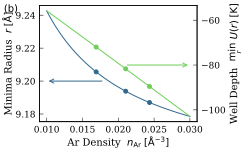

In [14]:
plt.style.reload_library()
with plt.style.context('./include/aps.mplstyle'):
    # Do many densities here and put a line through them, hilight three points from other plot
    fig,ax = plt.subplots(constrained_layout=True)
    ax2 = ax.twinx()
    ax.plot(different_densities,r_mins, color=plot_colors[3], lw=1)
    ax2.plot(different_densities,V_mins, color=plot_colors[-3], lw=1)
    ax.set_xlabel(r'Ar Density  $n_\mathrm{Ar}\; \mathrm{[\AA^{-3}]}$')
    ax.set_ylabel(r'Minima Radius  $r\; \mathrm{[\AA]}$')
    ax2.set_ylabel(r'Well Depth  $\min_r \ U(r)\; \mathrm{[K]}$')
    ax.annotate("", xy=(0.010,9.2), xytext=(0.018, 9.2), arrowprops=dict(arrowstyle="->",color=plot_colors[3]))
    ax2.annotate("", xy=(0.030,-80), xytext=(0.021, -80), arrowprops=dict(arrowstyle="->",color=plot_colors[-3]))
    ax.plot(argonDensityArr,argonDensityr_mins,color=plot_colors[3], ls='None', ms=4, marker='o', mfc=plot_colors[3])
    ax2.plot(argonDensityArr,argonDensityV_mins,color=plot_colors[-3], ls="None", ms=4,marker='o', mfc=plot_colors[-3])
    ax.annotate(r"$(\mathrm{b})$", xy=(-0.18,0.92), xytext=(-0.18,0.92),xycoords=ax.transAxes, 
        textcoords='offset points', ha='center', va='bottom',
        )
    fig.savefig('plots/effectivePotential_b.pdf')

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


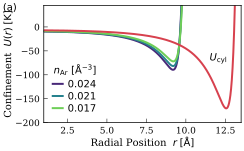

In [15]:
plt.style.reload_library()
with plt.style.context('./include/aps.mplstyle'):

    fig,ax = plt.subplots(constrained_layout=True)
    ax.set_ylim((-100,10))
    ax.set_xlim((1,10.5))
    ax.set_xlabel(r'Radial Position  $r\; \mathrm{[\AA]}$')
    ax.set_ylabel(r'Confinement  $U(r)\; \mathrm{[K]}$')

    ax.text(0.05,0.42,r'$n_\mathrm{Ar}\ \mathrm{[\AA^{-3}]}$',transform=ax.transAxes)
    ax.annotate(r"$(\mathrm{a})$", xy=(-0.171,0.93), xytext=(-0.171,0.93),xycoords=ax.transAxes, 
        textcoords='offset points', ha='center', va='bottom',
        )
    r = effective_potential_Ar[:,0]
    for j in range(effective_potential_Ar.shape[1] - 1):
        V_eff = effective_potential_Ar[:,j+1]
        ax.plot(r,V_eff,label='${:2.3f}$'.format(argonDensityArr[j]),color=plot_colors[3*j+1], lw=2)
    l = ax.legend(frameon=False,ncol=1,loc=3, handlelength=1)
    
    ax.plot(r_MCM41,effective_potential_MCM41,color='#d7414e',linestyle="-", lw=2)
    ax.annotate(r"$U_{\rm cyl}$", xy=(0.88,0.5), xytext=(0.88,0.5),xycoords=ax.transAxes, 
        textcoords='offset points', ha='center', va='bottom',
        )
    ax.set_xlim((1,13.5))
    ax.set_ylim((-200,45))
    
    #fig.savefig('plots/EP_Ar.svg',bbox_inches='tight')
    #fig.savefig('plots/EP_Ar.png',bbox_inches='tight',dpi=400)
    fig.savefig('plots/effectivePotential.pdf')

<div style="background:#3aba76; padding:10px; border-radius:5px"> 
    <h2>Isotherms</h2>
    </div>

In [18]:
density_vs_pressure_data=np.load("data/density_vs_pressure_T4.2.npz")
helium_isotherm_pressure = density_vs_pressure_data["helium_isotherm_pressure"]
helium_isotherm_density = density_vs_pressure_data["helium_isotherm_density"]
qmc_pressure = density_vs_pressure_data["qmc_pressure"]
qmc_density = density_vs_pressure_data["qmc_density"]
qmc_density_error = density_vs_pressure_data["qmc_density_error"]
mean_qmc_density_flat_idx = (qmc_pressure > .2) & (qmc_pressure < 1)
mean_helium_isotherm_density_flat_idx = (helium_isotherm_pressure > .3) & (helium_isotherm_pressure < .7)

mean_qmc_density_flat = np.mean(qmc_density[mean_qmc_density_flat_idx])
mean_helium_isotherm_density_flat = np.mean(helium_isotherm_density[mean_helium_isotherm_density_flat_idx])
mqdf = mean_qmc_density_flat
mhdf = mean_helium_isotherm_density_flat

#np.savez("data/chemical_potential_vs_pressure",P_P0=x,T=T,chemical_potential_T0=μ_exp[Tkey(T[0])],chemical_potential_T1=μ_exp[Tkey(T[1])])

In [19]:
chemical_potential_vs_pressure_data = np.load("data/chemical_potential_vs_pressure.npz")
P_P0 = chemical_potential_vs_pressure_data["P_P0"]
T_ = chemical_potential_vs_pressure_data["T"]
chemical_potential_T0 = chemical_potential_vs_pressure_data["chemical_potential_T0"]
chemical_potential_T1 = chemical_potential_vs_pressure_data["chemical_potential_T1"]
μ_exp=[chemical_potential_T0,chemical_potential_T1]

## Let's plot the inverse of this expression $P(\mu)$

In [20]:
x = {}
T = [1.6,4.2]
cμ = np.linspace(-100,1,100)
for i,cT in enumerate(T):
    x[Tkey(cT)] = helium.pressure(cμ,cT)/helium.pressure_SVP(cT)

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


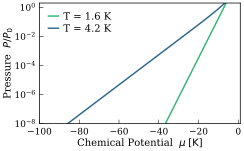

In [21]:
plt.style.reload_library()
with plt.style.context('./include/aps.mplstyle'):

    fig,ax = plt.subplots(constrained_layout=True)

    _colors = [color_names['Medium sea green'],color_names['Teal blue']]
    for i,cT in enumerate(T_):
        ax.plot(cμ,x[Tkey(cT)], label=f'T = {cT:3.1f} K', color=_colors[i])

    #plt.yscale('symlog')
    ax.set_yscale('log')
    ax.set_xlabel(r'Chemical Potential  $\mu\; \mathrm{[K]}$')
    ax.set_ylabel(r'Pressure  $P/P_0$')
    ax.set_ylim(1E-8,2)
    ax.set_xlim(-100,1.01)
    ax.legend(handlelength=1)
    
    fig.savefig('plots/pressure_vs_chemical_potential.pdf')

### With Inset

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


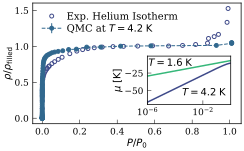

In [22]:
mqdf = mean_qmc_density_flat
mhdf = mean_helium_isotherm_density_flat
plt.style.reload_library()
with plt.style.context('./include/aps.mplstyle'):
    fig,ax = plt.subplots(constrained_layout=True)
    axin = ax.inset_axes([0.55, 0.16, 0.4, 0.4])
    _colors = [color_names['Medium sea green'],color_names['Dark slate blue']]
    for i,cT in enumerate(T_):
        axin.plot(P_P0,μ_exp[i], label=f'T = {cT:3.1f} K', color=_colors[i])

    #plt.yscale('symlog')
    axin.set_xscale('log')
    axin.set_ylabel(r'$\mu\; \mathrm{[K]}$')
    #axin.set_xlabel(r'$P/P_0$')
    axin.set_xlim(1E-6,1.01)
    
    axin.annotate(f"$T = {T[0]:3.1f}\; \mathrm{{K}}$", xy=(0.27,0.74), xytext=(0.27,0.74),xycoords=axin.transAxes, 
        textcoords='offset points', ha='center', va='bottom')
    axin.annotate(f"$T = {T[1]:3.1f}\; \mathrm{{K}}$", xy=(0.67,0.14), xytext=(0.67,0.14),xycoords=axin.transAxes, 
        textcoords='offset points', ha='center', va='bottom')
    #axin.legend(frameon=False)

    ax.plot(helium_isotherm_pressure,helium_isotherm_density/mhdf, label="Exp. Helium Isotherm",color=color_names['Dark slate blue'], ms=4, linestyle='None', marker='o',
            mec=color_names['Dark slate blue'],mfc='None', mew=1)
    ax.errorbar(qmc_pressure,qmc_density/mqdf,yerr=qmc_density_error/mqdf, 
                 marker='o', label=f"QMC at $T={T[-1]}\; \mathrm{{K}}$",color=color_names['Teal blue'], ms=4, lw=1, linestyle='--')
    ax.legend(frameon=False)

    #ax.set_ylabel(r"$\rho/\tilde{\rho}$")
    ax.set_ylabel(r"$\rho/\rho_{\rm filled}$")
    ax.set_xlabel(r"$P/P_0$")
    fig.savefig('plots/filling_the_pore.pdf')

### Combine with all QMC Data

0.018868268276904937
20.16748110767602
0.02184723017771156
1.151939775579109


'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


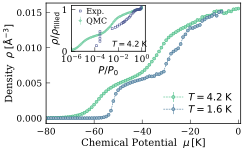

In [23]:
P0 = helium.pressure_SVP(T)
_P = {}
_colors = [color_names['Medium sea green'],color_names['Teal blue']]

plt.style.reload_library()
with plt.style.context('./include/aps.mplstyle'):
    fig,ax = plt.subplots(constrained_layout=True)
    axin = ax.inset_axes([0.13, 0.6, 0.38, 0.38])
    
    # plot the QMC data
    for i,cT in enumerate(T[::-1]):
        _P[Tkey(cT)] = helium.pressure(μqmc[Tkey(cT)],cT)/helium.pressure_SVP(cT)
        ρsvp = helium.density_SVP(cT)/helium.const['mass']*1E-30
        print(ρsvp)
        
        ax.errorbar(μqmc[Tkey(cT)],ρqmc[Tkey(cT)],yerr=Δρqmc[Tkey(cT)], 
                     marker='o', color=_colors[i],markersize=3,lw=0.5, mew=0.5,
                    mfc=colortools.get_alpha_hex(_colors[i],0.5), label=f"$T = {cT:.1f}\; \mathrm{{K}}$", ls='--')
        
        # Plot the inset
        print(_P[Tkey(cT)][0])
        if (np.abs(cT-4.2) < 1E-6):
            axin.errorbar(qmc_pressure,qmc_density/mqdf,yerr=qmc_density_error/mqdf, 
                         marker='o', color=_colors[i],markersize=2,lw=0.25, mew=0.25,
                        mfc=colortools.get_alpha_hex(_colors[i],0.5), label='QMC', ls='--')
    
    scale = helium_isotherm_density[-10]
    axin.plot(helium_isotherm_pressure,helium_isotherm_density/mhdf, label="Exp.",color=color_names['Dark slate blue'], ms=2, 
              linestyle='None', marker='s', mec=color_names['Dark slate blue'],mfc='None', mew=0.5, zorder=10)
    
    axin.annotate(f"$T = {T[1]:3.1f}\; \mathrm{{K}}$", xy=(0.55,0.1), xytext=(0.55,0.1),xycoords=axin.transAxes, fontsize=8)
    
    axin.set_xlim(1E-6,2)
    axin.set_xscale('log')
    axin.set_xticks([1e-6,0.0001, 0.01, 1])
    axin.set_ylim(0,1.1)
    axin.legend(fontsize=8, loc=(0.05,0.5), handlelength=0.5)
    axin.set_xlabel('$P/P_0$')
    axin.set_ylabel(r"$\rho/\rho_{\rm filled}$")

    ax.set_xlim(-80,1)
    ax.legend(loc='lower right')
    ax.set_ylabel(r"Density  $\rho\; [\mathrm{\AA}^{-3}]$")
    ax.set_xlabel(r"Chemical Potential  $\mu\, [\mathrm{K}]$")
    fig.savefig('plots/filling_the_pore.pdf')

<div style="background:#3aba76; padding:10px; border-radius:5px"> 
    <h2>Radial density</h2>
    </div>

### Plot showing both temperatures

Because $P(\mu)$ is exponential and depends on $T$, we need to make a special color index map

In [29]:
from collections import defaultdict
T = [1.6,4.2]
P0 = helium.pressure_SVP(T)
_P = {}
μmin = -50

num_colors = 1000
P_spread = np.geomspace(1E-12, 
                        1.01*helium.pressure(μqmc[Tkey(4.2)][0],cT)/helium.pressure_SVP(4.2), num=num_colors)
    
P_index = defaultdict(list)
for i,cT in enumerate(T):
    _P[Tkey(cT)] = helium.pressure(μqmc[Tkey(cT)],cT)/helium.pressure_SVP(cT)
    print(cT,helium.pressure(μmin,cT)/helium.pressure_SVP(cT))
    print(cT,helium.pressure(μqmc[Tkey(cT)][0],cT)/helium.pressure_SVP(cT))
    for j,cP in enumerate(_P[Tkey(cT)]):
        found_index = np.searchsorted(P_spread,cP)
        P_index[Tkey(cT)].append(found_index)

colors1 = colortools.get_linear_colors('viridis',len(μqmc[Tkey(4.2)][μqmc[Tkey(4.2)]>μmin]),reverse=False)
colors_pressure = colortools.get_linear_colors('viridis',num_colors+1,reverse=True)
print(len(colors1),len(colors_pressure))

1.6 2.4163770792702753e-12
1.6 1.151939775579109
4.2 5.11575618568111e-05
4.2 20.16748110767602
50 1001


In [42]:
ρrad[Tkey(T[-1])]['u = 0.00 -- r [Å]']

array([ 0.     ,  0.07755,  0.1551 ,  0.2326 ,  0.3102 ,  0.3877 ,
        0.4653 ,  0.5428 ,  0.6204 ,  0.6979 ,  0.7755 ,  0.853  ,
        0.9306 ,  1.008  ,  1.086  ,  1.163  ,  1.241  ,  1.318  ,
        1.396  ,  1.473  ,  1.551  ,  1.629  ,  1.706  ,  1.784  ,
        1.861  ,  1.939  ,  2.016  ,  2.094  ,  2.171  ,  2.249  ,
        2.326  ,  2.404  ,  2.482  ,  2.559  ,  2.637  ,  2.714  ,
        2.792  ,  2.869  ,  2.947  ,  3.024  ,  3.102  ,  3.18   ,
        3.257  ,  3.335  ,  3.412  ,  3.49   ,  3.567  ,  3.645  ,
        3.722  ,  3.8    ,  3.877  ,  3.955  ,  4.033  ,  4.11   ,
        4.188  ,  4.265  ,  4.343  ,  4.42   ,  4.498  ,  4.575  ,
        4.653  ,  4.731  ,  4.808  ,  4.886  ,  4.963  ,  5.041  ,
        5.118  ,  5.196  ,  5.273  ,  5.351  ,  5.428  ,  5.506  ,
        5.584  ,  5.661  ,  5.739  ,  5.816  ,  5.894  ,  5.971  ,
        6.049  ,  6.126  ,  6.204  ,  6.282  ,  6.359  ,  6.437  ,
        6.514  ,  6.592  ,  6.669  ,  6.747  ,  6.824  ,  6.90

In [45]:
ρrad[Tkey(T[-1])]['u = 0.00 -- r [Å]']

array([ 0.     ,  0.07755,  0.1551 ,  0.2326 ,  0.3102 ,  0.3877 ,
        0.4653 ,  0.5428 ,  0.6204 ,  0.6979 ,  0.7755 ,  0.853  ,
        0.9306 ,  1.008  ,  1.086  ,  1.163  ,  1.241  ,  1.318  ,
        1.396  ,  1.473  ,  1.551  ,  1.629  ,  1.706  ,  1.784  ,
        1.861  ,  1.939  ,  2.016  ,  2.094  ,  2.171  ,  2.249  ,
        2.326  ,  2.404  ,  2.482  ,  2.559  ,  2.637  ,  2.714  ,
        2.792  ,  2.869  ,  2.947  ,  3.024  ,  3.102  ,  3.18   ,
        3.257  ,  3.335  ,  3.412  ,  3.49   ,  3.567  ,  3.645  ,
        3.722  ,  3.8    ,  3.877  ,  3.955  ,  4.033  ,  4.11   ,
        4.188  ,  4.265  ,  4.343  ,  4.42   ,  4.498  ,  4.575  ,
        4.653  ,  4.731  ,  4.808  ,  4.886  ,  4.963  ,  5.041  ,
        5.118  ,  5.196  ,  5.273  ,  5.351  ,  5.428  ,  5.506  ,
        5.584  ,  5.661  ,  5.739  ,  5.816  ,  5.894  ,  5.971  ,
        6.049  ,  6.126  ,  6.204  ,  6.282  ,  6.359  ,  6.437  ,
        6.514  ,  6.592  ,  6.669  ,  6.747  ,  6.824  ,  6.90

In [49]:
'[Å]' == '[Å]'

False

In [56]:
ρrad[Tkey(T[-1])]['u = 0.00 -- Δρ(r)']

array([1.02578336e-03, 8.69123450e-04, 7.55681344e-04, 6.11815203e-04,
       5.41191017e-04, 4.54906997e-04, 3.54963115e-04, 2.97379962e-04,
       2.64985153e-04, 2.58554183e-04, 2.56220346e-04, 2.42975556e-04,
       2.25154686e-04, 2.14933227e-04, 1.76798179e-04, 1.52007107e-04,
       1.18384508e-04, 9.23178957e-05, 7.25244796e-05, 5.78181306e-05,
       4.48926230e-05, 3.73128976e-05, 3.38265406e-05, 3.70187631e-05,
       4.01584426e-05, 4.76595709e-05, 5.52096643e-05, 6.65455021e-05,
       7.42344949e-05, 8.44711340e-05, 9.53547908e-05, 1.02542158e-04,
       1.17619873e-04, 1.25445248e-04, 1.25487308e-04, 1.29316463e-04,
       1.32069118e-04, 1.30040792e-04, 1.40932579e-04, 1.56587750e-04,
       1.92614162e-04, 2.42630454e-04, 2.82982719e-04, 3.30132869e-04,
       3.56329635e-04, 3.80758928e-04, 3.77297573e-04, 3.69546753e-04,
       3.39711583e-04, 3.02071135e-04, 2.59124087e-04, 2.18011345e-04,
       1.77447367e-04, 1.42077869e-04, 1.10118175e-04, 8.35435268e-05,
      

In [57]:
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

plt.style.reload_library()
with plt.style.context('./include/aps.mplstyle'):
    figsize=plt.rcParams['figure.figsize']
    fig,axes = plt.subplots(2,1,figsize=(figsize[0],1.9*figsize[1]), sharex=False, sharey=True, constrained_layout=True)
    μmin = -50

    for i,cT in enumerate(T[::-1]):
        #idx = 0
        for j,cμ in enumerate(μqmc[Tkey(cT)]):
            if cμ > μmin:
                idx = P_index[Tkey(cT)][j]
                #print(idx)
                x = ρrad[Tkey(cT)][f'{μkey(cμ)} -- r [Å]']
                y = ρrad[Tkey(cT)][f'{μkey(cμ)} -- ρ(r)']
                Δy = ρrad[Tkey(cT)][f'{μkey(cμ)} -- Δρ(r)']
                try:
                    axes[i].errorbar(x,y,yerr=Δy, marker='o', mew=0.25, lw=0.25, ms=1, 
                                     color=colortools.get_alpha_hex(colors_pressure[idx],0.8), elinewidth=0.25, 
                                    mfc=colors_pressure[idx], mec=colors_pressure[idx], ecolor=colors_pressure[idx])
                except:
                    print(idx)
                #idx += 1

        axes[i].annotate(f'$T = {cT:3.1f}\; \mathrm{{K}}$', xy=(0.73,0.6), xytext=(0.73,0.6),
                         xycoords=axes[i].transAxes, fontsize=10)
        axes[i].set_xlim(0,11);
        axes[i].set_ylim(0,0.21);
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(2.5))

        axes[i].set_ylabel(r'Rad. Density $\rho_{\rm rad}(r)\; [\mathrm{\AA}^{-3}]$')

    axes[-1].set_xlabel(r'Radial Position  $r\; [\mathrm{\AA}]$')
    
    # create the colorbar
    #vmin = helium.pressure(μmin,4.2)/helium.pressure_SVP(4.2)
    #vmax = 1.0
    vmin = P_spread[0]
    vmax = P_spread[-1]
    sm = plt.cm.ScalarMappable(cmap=mpl.cm.viridis_r, norm=mplcolors.LogNorm(vmin=vmin, vmax=vmax))
    sm._A = []
    
    axins1 = inset_axes(axes[0],
                    width="70%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='upper center')
    fig.colorbar(sm, cax=axins1, label=r"$P/P_0$", orientation='horizontal',
                ticks=[1e-12,1e-8,1e-4,1])
    
    fig.savefig('plots/radialDensity.pdf')

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


<div style="background:#3aba76; padding:10px; border-radius:5px"> 
    <h2>Linear density</h2>
    </div>

### Plot the Core Density and Coverage

First we compute the effective linear densities for bulk helium


In [58]:
ρsvp_bulk = {}
from numpy import pi as π
Rmin = 1.706 # Å

for i,cT in enumerate(T):
    ρsvp_bulk[Tkey(cT)] = helium.density_SVP(cT)/helium.const['mass']*1E-30
print(ρsvp_bulk)

{'T = 1.6 K': 0.02184723017771156, 'T = 4.2 K': 0.018868268276904937}


#### Load the pore image from disk

In [59]:
pore_config_image = plt.imread("data/mcm41_4He_config.png")

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


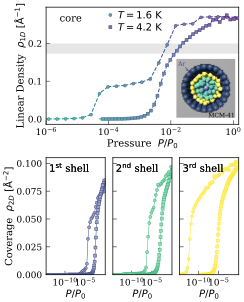

In [60]:
plt.style.reload_library()
with plt.style.context('./include/aps.mplstyle'):
    fig = plt.figure(figsize=(figsize[0],2*figsize[1]),constrained_layout=True)
    gs = fig.add_gridspec(nrows=2, ncols=3)
    ax = [fig.add_subplot(gs[0, :])]
    for i in range(3):
        ax.append(fig.add_subplot(gs[1,i]))


    labels = ['core',r'$1^{\rm st}$ shell', r'$2^{\rm nd}$ shell', r'$3^{\rm rd}$ shell']
    markers = ['o','s']
    shell_color = [colors_pressure[0], color_names['Dark slate blue'], color_names['Jungle green'], color_names['Maximum yellow']]
    shell_color = [colors_pressure[0],color_names['Dark slate blue'], color_names['Medium sea green'], color_names['Maximum yellow']]
    Tpos = [(0.01,0.1),(0.65,0.1)]
    
            
    # plot the effective 1D density for bulk helium
    A = π*Rmin**2
    ax[0].fill_between(P_spread,ρsvp_bulk[Tkey(4.2)]*A,ρsvp_bulk[Tkey(1.6)]*A,color='k', alpha=0.1, ec='None',lw=0)
    
    axin = ax[0].inset_axes([0.58, 0.05, 0.5, 0.5])
    axin.set_aspect('equal')
    axin.set_yscale('linear')
    axin.imshow(pore_config_image, rasterized=True, interpolation=None)
    axin.annotate('MCM-41', xy=(0.99,0.02), xytext=(0.99,0.02),xycoords=axin.transAxes, fontsize=6, ha='right')
    axin.annotate('Ar', xy=(0.025,0.9), xytext=(0.0250,0.9),xycoords=axin.transAxes, fontsize=6, ha='left', color='#3e4989')
    axin.annotate("", xy=(0.225, 0.775), xytext=(0.125,0.9), arrowprops=dict(arrowstyle="->",color='#3e4989',lw=0.5),
                  xycoords='axes fraction', textcoords='axes fraction', fontsize=6, color='#3e4989', ha='right')
    axin.axis('off')
        

    num_cols = len(μqmc[Tkey(4.2)][(μqmc[Tkey(4.2)]>μmin)])
    for i,cT in enumerate(T):
        μmin = -50

        PoP0 = helium.pressure(μqmc[Tkey(cT)][μqmc[Tkey(cT)] > μmin],cT)/helium.pressure_SVP(cT)
        PoP0_full = helium.pressure(μqmc[Tkey(cT)],cT)/helium.pressure_SVP(cT)
        y = ρcov[Tkey(cT)][μqmc[Tkey(cT)] > μmin]
        
        #ax[0].annotate(f'$T = {cT}\ \mathrm{{K}}$', xy=Tpos[i], xytext=Tpos[i],xycoords=ax[0].transAxes, fontsize=10)

        for j,cμ in enumerate(μqmc[Tkey(cT)]):
            if cμ > μmin:
                
                idx = P_index[Tkey(cT)][j]
                x = helium.pressure(cμ,cT)/helium.pressure_SVP(cT)
                y = ρcov[Tkey(cT)][j][0]
                
                if np.abs(cμ+20) < 1e-6:
                    label = f'$T = {cT}\ \mathrm{{K}}$'
                else:
                    label = ''
                
                ax[0].plot(x,y,marker=markers[i], mec=colors_pressure[idx], mfc=colortools.get_alpha_hex(colors_pressure[idx],0.7), mew=0.5, 
                       markersize=3, lw=0.5, ls='None', zorder=10, label=label)

                dx = helium.pressure(μqmc[Tkey(cT)][j:j+2],cT)/helium.pressure_SVP(cT)
                dy = ρcov[Tkey(cT)][j:j+2,0]
                ax[0].plot(dx,dy,lw=1, marker='None', linestyle='--', color=colors_pressure[idx], mew=1)

        # plot the coverage in the shells
        for k in range(1,4):
            ax[k].plot(PoP0_full,ρcov[Tkey(cT)][:,k],marker=markers[i], mfc=colortools.get_alpha_hex(shell_color[k],0.5), color=shell_color[k], 
                       markersize=3, lw=0.5, mew=0.5)
            ax[k].annotate(labels[k], xy=(0.05,0.88), xytext=(0.05,0.88),xycoords=ax[k].transAxes, fontsize=10)

    ax[0].annotate(labels[0], xy=(0.05,0.88), xytext=(0.07,0.88),xycoords=ax[0].transAxes, fontsize=10, zorder=10)
    ax[0].legend(loc=(0.3,0.75), handlelength=0.5)
    
    for cax in ax:
        cax.set_xscale('log')
        
    ax[0].set_xlabel('Pressure  $P/P_0$')
    ax[0].set_xlim(1e-6,1.5)

    for cax in ax[1:]:
        cax.set_xlim(2E-15,1)
        cax.set_ylim(0,0.105)
        cax.set_xlabel('$P/P_0$')
        cax.set_xticks([1E-10,1E-5])

    ax[0].set_ylabel(r'Linear Density  $\rho_{1D}\ [\mathrm{\AA}^{-1}]$')
    ax[1].set_ylabel(r'Coverage  $\rho_{2D}\ [\mathrm{\AA}^{-2}]$')

    ax[2].set_yticklabels([])
    ax[3].set_yticklabels([])

    fig.savefig('plots/linearDensity.pdf', dpi=1000)

<div style="background:#3aba76; padding:10px; border-radius:5px"> 
    <h2>finite size effects</h2>
    </div>

In [30]:
finite_size_effect_radial_data = np.load("data/finite_size_effect_radial.npz")

L_fse = finite_size_effect_radial_data["L"]
distance_from_center_fse = finite_size_effect_radial_data["distance_from_center"]
radial_density_fse = finite_size_effect_radial_data["radial_density"]
radial_density_error_fse = finite_size_effect_radial_data["radial_density_error"]


'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


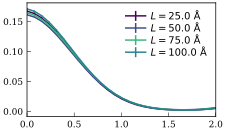

In [34]:
plt.style.reload_library()
with plt.style.context('./include/aps.mplstyle'):
    fig,ax = plt.subplots()
    _colors= [color_names['Russian violet'],color_names['Dark slate blue'],color_names['Medium sea green'],color_names['Celadon green']]
    for i,cL in enumerate(L_fse):
        x = distance_from_center_fse[i]
        y = radial_density_fse[i]
        yerr = radial_density_error_fse[i]
        ax.errorbar(x,y,yerr,label="$L={}\ \mathrm{{\AA}}$".format(cL),color=_colors[i])
    ax.legend(frameon=False,ncol = 1)
    ax.set_xlim((0,2))
    fig.savefig('plots/finite_size_scaling_radial_density.pdf',bbox_inches='tight')

(0, 2)

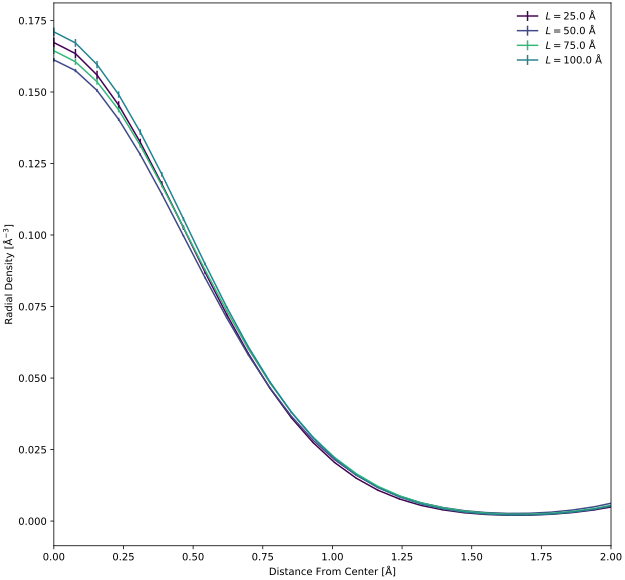

In [35]:
fig,ax = plt.subplots(figsize=(10,10))
_colors= [color_names['Russian violet'],color_names['Dark slate blue'],color_names['Medium sea green'],color_names['Celadon green']]
inner_core_radial_density_max = np.zeros(len(L_fse))
inner_core_radial_density_max_error = np.zeros(len(L_fse))
for i,cL in enumerate(L_fse):
    x = distance_from_center_fse[i]
    y = radial_density_fse[i]
    yerr = radial_density_error_fse[i]
    
    inner_core_radial_density_max[i] = y[0]
    inner_core_radial_density_max_error[i] = yerr[0]
    ax.errorbar(x,y,yerr,label="$L={}\ \mathrm{{\AA}}$".format(cL),color=_colors[i])
ax.legend(frameon=False,ncol = 1)
ax.set_xlabel(r'Distance From Center $[\mathrm{\AA}]$')
ax.set_ylabel(r'Radial Density $[\mathrm{\AA}^{-3}]$')
ax.set_xlim((0,2))

Text(0.5, 0, 'Length of Pore $\\mathrm{[\\AA]}$')

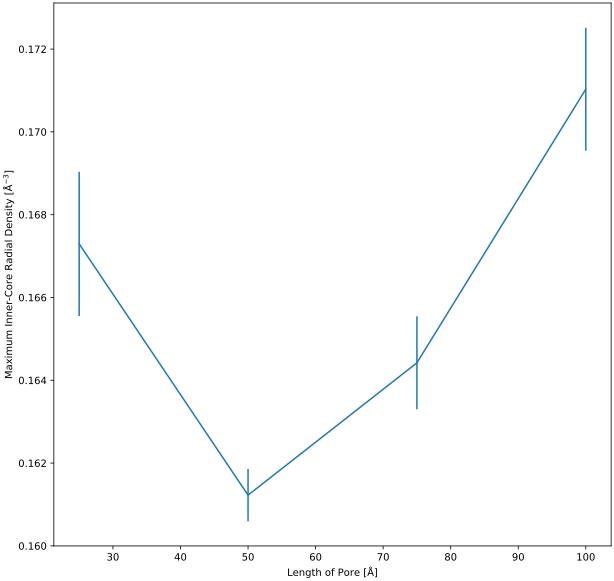

In [36]:
fig,ax = plt.subplots(figsize=(10,10))
ax.errorbar(L_fse,inner_core_radial_density_max,inner_core_radial_density_max_error)
ax.set_ylabel(r"Maximum Inner-Core Radial Density $[\mathrm{\AA}^{-3}]$")
ax.set_xlabel(r"Length of Pore $\mathrm{[\AA]}$")

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


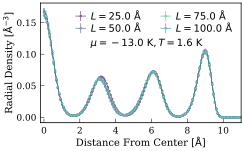

In [140]:
plt.style.reload_library()
with plt.style.context('./include/aps.mplstyle'):
    fig,ax = plt.subplots(constrained_layout=True)
    _colors= [color_names['Russian violet'],color_names['Dark slate blue'],
              color_names['Medium sea green'],color_names['Celadon green']]
    for i,cL in enumerate(L_fse):
        x = distance_from_center_fse[i]
        y = radial_density_fse[i]
        yerr = radial_density_error_fse[i]
        
        ax.errorbar(x,y,yerr,label=f"$L={cL}\ \mathrm{{\AA}}$",marker='o', mew=0.25, lw=0.5, ms=2, 
                    color=_colors[i], elinewidth=0.5, 
                    mfc=colortools.get_alpha_hex(_colors[i],0.5), mec=_colors[i], ecolor=_colors[i])
                    
                    #color=_colors[i])
    
    ax.annotate(f"$\mu=-13.0\ \mathrm{{K}}, T = {T[0]}\ \mathrm{{K}}$", xy=(0.25,0.64), 
                xytext=(0.25,0.64),xycoords=ax.transAxes, fontsize=10, zorder=10)

    ax.legend(frameon=False,ncol = 2,handlelength=1)
    ax.set_xlabel(r'Distance From Center $[\mathrm{\AA}]$')
    ax.set_ylabel(r'Radial Density $[\mathrm{\AA}^{-3}]$')
    ax.set_xlim(-0.2,11);
    #ax.set_xlim((0,2))
    fig.savefig('plots/finite_size_scaling_radial_density.pdf',dpi=300)

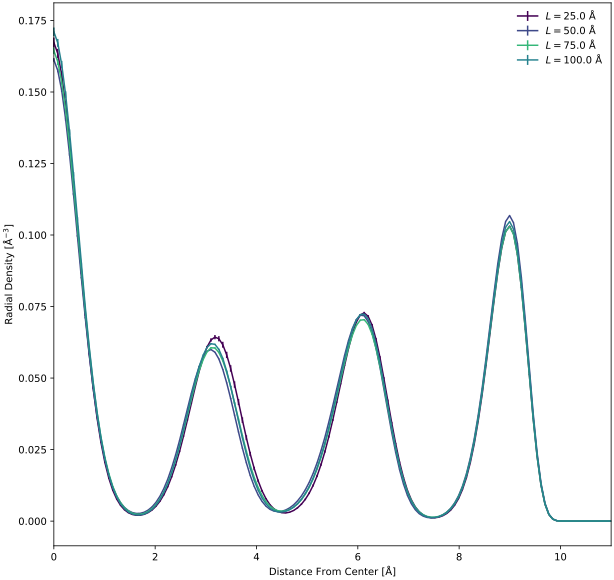

In [41]:
fig,ax = plt.subplots(figsize=(10,10))
_colors= [color_names['Russian violet'],color_names['Dark slate blue'],color_names['Medium sea green'],color_names['Celadon green']]
for i,cL in enumerate(L_fse):
    x = distance_from_center_fse[i]
    y = radial_density_fse[i]
    yerr = radial_density_error_fse[i]
    ax.errorbar(x,y,yerr,label="$L={}\ \mathrm{{\AA}}$".format(cL),color=_colors[i])
ax.legend(frameon=False,ncol = 1)
ax.set_xlabel(r'Distance From Center $[\mathrm{\AA}]$')
ax.set_ylabel(r'Radial Density $[\mathrm{\AA}^{-3}]$')
ax.set_xlim(0,11);
#ax.set_xlim((0,2))

In [142]:
from scipy.integrate import simps

def simps_error_const_dx_odd(x_error,dx):
    return np.sqrt(((sum(16*x_error[1:-1:2]**2) + sum(4*x_error[2:-2:2]**2) + x_error[0]**2 + x_error[-1]**2)*dx**2)/9)

def simps_error_const_dx_even_avg(x_error,dx):
    es = x_error**2
    return dx*dx*((sum(es[2:-2]) + (25*es[0] + 169*es[-2] + 169*es[1] + 25*es[-1])/144))

_colors= [color_names['Russian violet'],color_names['Dark slate blue'],color_names['Medium sea green'],color_names['Celadon green']]
λ = np.zeros(len(L_fse))
λ_error = np.zeros(len(L_fse))
for i,cL in enumerate(L_fse):
    x = distance_from_center_fse[i]
    y = radial_density_fse[i]
    yerr = radial_density_error_fse[i]
    min_idx = np.argmin(y[x<=2])
    x_min = x[min_idx]
    y_min = y[min_idx]
    y_min_error = yerr[min_idx]
    print(x_min)
    _λ = simps(x[:min_idx]*y[:min_idx],x[:min_idx])*2*np.pi
    print(_λ)
    _λ_error = 0.0
    if len(x[:min_idx])%2:
        _λ_error = simps_error_const_dx_odd(x[:min_idx]*yerr[:min_idx],x[1]-x[0])*2*np.pi
    else:
        _λ_error = simps_error_const_dx_odd(x[:min_idx]*yerr[:min_idx],x[1]-x[0])*2*np.pi
    λ[i] = _λ
    λ_error[i] = _λ_error

1.629
0.24815154537921869
1.629
0.24874601915238195
1.706
0.25777446101788
1.629
0.25862537938375185


In [145]:
L_fse

array([ 25.,  50.,  75., 100.])

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


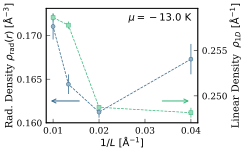

In [149]:
plt.style.reload_library()
with plt.style.context('./include/aps.mplstyle'):
    fig,ax = plt.subplots(constrained_layout=True)
    ax2 = ax.twinx()
    ax.errorbar(1/L_fse,inner_core_radial_density_max,inner_core_radial_density_max_error,lw=0.75,
                color=color_names['Teal blue'],linestyle="--",marker="o",markersize=4, mew=0.5,
               ecolor=color_names['Teal blue'], mfc=colortools.get_alpha_hex(color_names['Teal blue'],0.5))
    #ax.set_ylabel(r"$\rho(r\to 0)\ [\mathrm{\AA}^{-3}]$")
    ax.set_ylabel(r"Rad. Density $\rho_{\rm rad}(r)\; [\mathrm{\AA}^{-3}]$")
    ax.set_xlabel(r"$1/L\ \mathrm{[\AA^{-1}]}$")
    ax2.errorbar(1/L_fse,λ,λ_error,color=color_names['Medium sea green'],linestyle="--",marker="s",
                 markersize=4, mew=0.5,lw=0.75,ecolor=color_names['Medium sea green'],
                 mfc=colortools.get_alpha_hex(color_names['Medium sea green'],0.5))
    
    ax2.set_ylabel(r"Linear Density  $\rho_{1D}\ [\mathrm{\AA}^{-1}]$")
    #ax2.set_ylabel(r"$\lambda\ \mathrm{[\AA^{-1}]}$")
    ax2.set_xlabel(r"$1/L\ \mathrm{[\AA^{-1}]}$")
    ax.annotate(r"$\mu=-13.0\ \mathrm{K}$", xy=(0.95,0.95), xytext=(0.95,0.95),xycoords=ax.transAxes, 
            textcoords='offset points', ha='right', va='top',
            )

    ax.annotate("", xy=(1/110,0.1625), xytext=(1/62,0.1625), arrowprops=dict(arrowstyle="->",color=color_names['Teal blue']))
    ax.annotate("", xy=(1/25,0.1625), xytext=(1/30, 0.1625), arrowprops=dict(arrowstyle="->",color=color_names['Medium sea green']))

    #ax2.annotate("", xy=(1/25,0.257), xytext=(1/66, 0.257), arrowprops=dict(arrowstyle="->",color=color_names['Medium sea green']))

    #ax.annotate("", xy=(0.010,9.2), xytext=(0.018, 9.2), arrowprops=dict(arrowstyle="->",color=plot_colors[3]))

    #ax.set_xticks([25,50,75,100])

    #ax.set_xticks(0.01,0.1)
    fig.savefig(plotDir + 'finite_size_scaling_inner_core.pdf',dpi=300)
    fig.savefig(plotDir + 'finite_size_scaling_inner_core.png',dpi=300)

In [151]:
25/3.4

7.352941176470589

In [150]:
λ*L_fse

array([ 6.20378863, 12.43730096, 19.33308458, 25.86253794])

<div style="background:#3aba76; padding:10px; border-radius:5px"> 
    <h2>Finite τ effects</h2>
</div>

In [135]:
from scipy.optimize import curve_fit

# load the data
data_ = np.genfromtxt('../Data/estimator-t-reduce-T-01.600-u--050.000-L-025.000.dat', names=True)
#data_ = np.genfromtxt('../Data/estimator-t-reduce-T-01.600-u-+000.000-L-025.000.dat', names=True)


τ,EoN,ΔEoN = data_['t'],data_['EN'],data_['ΔEN']

# perform a simple fit to τ^4
def fit_tau(x,a,b):
    return a + b*x**2

popt, pcov = curve_fit(fit_tau, τ[:-6], EoN[:-6], sigma=ΔEoN[:-6], p0=[-50,-1000])

fit_τ = np.linspace(0,0.02,100)
fit_EoN = fit_tau(fit_τ,*popt)
print(popt,np.sqrt(np.diag(pcov)))

[  -50.19870723 -7545.59173054] [3.29930938e-03 6.53757751e+01]


'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


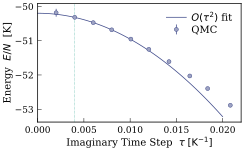

In [137]:
with plt.style.context('./include/aps.mplstyle'):
    figsize=plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]), constrained_layout=True)

    ax.plot(fit_τ,fit_EoN, color=color_names['Dark slate blue'], lw=0.75, label=r'$O(\tau^2)$ fit')
    ax.errorbar(τ,EoN,yerr=ΔEoN, linestyle='None', markersize=4, mew=0.5, 
                 mfc=colortools.get_alpha_hex(color_names['Dark slate blue'],0.5), mec=color_names['Dark slate blue'], 
                 ecolor=color_names['Dark slate blue'], marker='o', capsize=0, elinewidth=0.75, label='QMC')
    ax.axvline(x=0.00401, lw=0.5, ls=':', color=color_names['Jungle green'])


    ax.set_ylabel('Energy  $E/N$  [K]')
    ax.set_xlabel(r'Imaginary Time Step  $\tau\; [\mathrm{K}^{-1}]$')
    ax.set_xlim(0,0.022)
    ax.legend()
    plt.savefig('plots/EoN_vs_tau.pdf')